In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks/Moore')
from central_import import *

figure_directory = '../../../Figures/ModelCompare/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
#Calling the input file and shuffling the dataset
data = pd.read_parquet('../DataBuild/DownstreamTrackTrainingData.parquet').sample(frac=1,random_state=51)


#Defining Target Variable
x=data.drop(['isMatched'],axis=1)
y=data['isMatched'].astype(int)

columns=np.array(['P','Pt','Tx','Ty','Eta','Phi', 'X','Y','nUTHits','Chi2PerDoF'])
x.columns=columns

#Training Data
print(f"Dimension of the Data is : ",x.shape)
display(x.head())


Dimension of the Data is :  (2723937, 10)


,P,Pt,Tx,Ty,Eta,Phi,X,Y,nUTHits,Chi2PerDoF
433784,8189.772090,325.211148,-0.016746,-0.036040,-43.085033,-86.561920,3.918919,-2.005760,4,0.172747
1694589,8486.208200,878.609839,0.100799,-0.025982,246.978638,-62.572239,2.958313,-0.252271,4,0.543546
1437215,2809.355517,240.200632,0.032981,-0.079223,61.566750,-190.253845,3.150550,-1.176311,4,0.320558
177554,22305.965467,572.987270,-0.015344,0.020612,-39.130081,49.863842,4.354728,2.210740,4,0.211324
1407145,6983.081318,315.091139,0.032878,0.030971,87.272003,73.359505,3.791021,0.755543,4,0.423034


In [3]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=51)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=51)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

In [4]:
rocScores=[]
f1Scores=[]
for model in models_:
    model.fit(x_train,y_train)
    # Model Evaluation (Balanced Data)
    y_predict=model.predict(x_test)
    rocScores.append(round(roc_auc_score(y_test,y_predict)*100,2))
    f1Scores.append(round(f1_score(y_test,y_predict)*100,2))
    print(model)
    print(f'ROC-AUC Score : ',round(roc_auc_score(y_test,y_predict)*100,2),'%')
    print(f'F1 Score : ',round(f1_score(y_test,y_predict)*100,2),'%')

modelMetrics=pd.DataFrame(modelNames,columns=["ModelNames"])
modelMetrics['ROC']=rocScores
modelMetrics['F1']=f1Scores
modelMetrics.to_csv("ModelMetrics.csv",index=False)


LogisticRegression()
ROC-AUC Score :  66.71 %
F1 Score :  79.18 %
DecisionTreeClassifier()
ROC-AUC Score :  67.55 %
F1 Score :  78.88 %
RandomForestClassifier()
ROC-AUC Score :  75.38 %
F1 Score :  86.96 %
GradientBoostingClassifier()
ROC-AUC Score :  72.08 %
F1 Score :  83.66 %
AdaBoostClassifier()
ROC-AUC Score :  69.61 %
F1 Score :  79.04 %
KNeighborsClassifier()
ROC-AUC Score :  70.22 %
F1 Score :  86.35 %
MLPClassifier()
ROC-AUC Score :  76.24 %
F1 Score :  89.97 %
ROC-AUC Score :  79.74 %
F1 Score :  90.62 %


In [5]:
modelMetrics=pd.read_csv("ModelMetrics.csv")

In [6]:
modelMetrics

,ModelNames,ROC,F1
0,Logistic,66.71,79.18
1,DecisionTree,67.55,78.88
2,RandomForest,75.38,86.96
3,GradientBoosting,72.08,83.66
4,AdaBoost,69.61,79.04
5,KNN,70.22,86.35
6,MLP,76.24,89.97
7,CatBoost,79.74,90.62


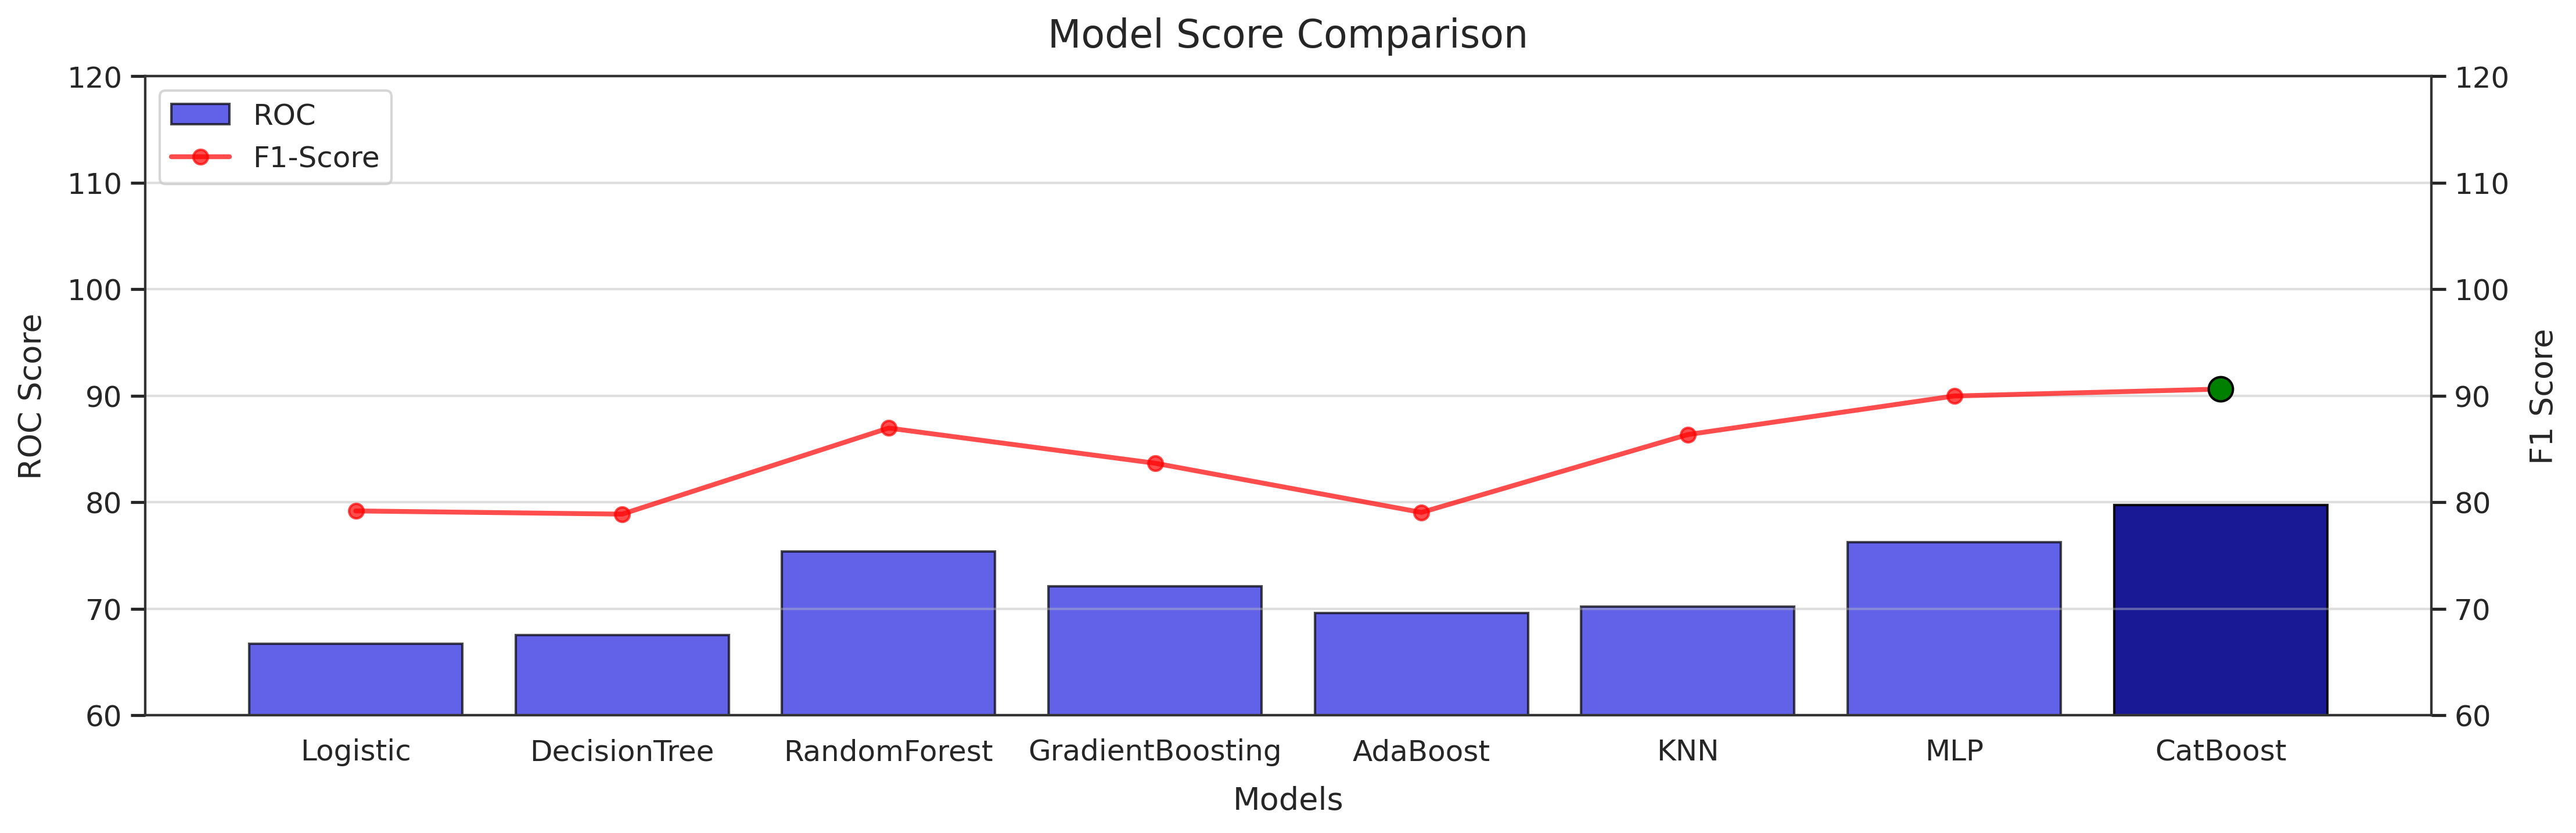

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot all ROC bars except the last one
sns.barplot(
    x="ModelNames",
    y="ROC",
    data=modelMetrics.iloc[:-1],
    color='blue',
    edgecolor='black',
    alpha=0.7,
    ax=ax,
    label='ROC'
)

# Plot the last ROC bar differently
last_idx = modelMetrics.index[-1]
ax.bar(
    modelMetrics.loc[last_idx, 'ModelNames'],
    modelMetrics.loc[last_idx, 'ROC'],
    color='darkblue',
    edgecolor='black',
    alpha=0.9
)

# Plot the F1-score as a line
ax2 = ax.twinx()
ax2.plot(
    modelMetrics['ModelNames'],
    modelMetrics['F1'],
    color='red',
    marker='o',
    linewidth=2,
    alpha=0.7,
    label='F1-Score'
)

# Highlight last F1-score marker differently
ax2.plot(
    modelMetrics.loc[last_idx, 'ModelNames'],
    modelMetrics.loc[last_idx, 'F1'],
    marker='o',
    markersize=10,
    markerfacecolor='green',
    markeredgecolor='black',
)

# Axis and title
ax.set_xlabel("Models")
ax.set_ylabel("ROC Score")
ax2.set_ylabel("F1 Score")
ax.set_ylim(60, 120)
ax2.set_ylim(60, 120)
plt.title("Model Score Comparison")


handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Tight layout
plt.tight_layout()
plt.savefig(f"{figure_directory}/Downstream_ModelCompare.png")
plt.show()


In [8]:
# End of notebook